# Estimating phase-amplitude coupling in simulated data

#### This notebook simulates a neural population that is biased to fire at a preferred phase in a low-frequency oscillation. A local field potential (LFP) is then calculated, and four metrics of PAC are applied to the simulated LFP

Imports

In [7]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from NeuroTools import stgen
from pacpy.pac import pac
%matplotlib inline

Simulate spike trains

In [3]:
np.random.seed(1)
stg = stgen.StGen()
mod_frac = np.arange(0,1,.1) #Phase-dependent modulation is this fraction of spikes
mod_f_mu = 20.0 #Mean modulation frequency
mod_f_std = 2.0 #StDev of modulation frequency
firing_rate = 10.0 #Firing rate for each neuron in Hz
dt = .001
nNeu = 100.0

E = len(mod_frac)
Tepochs = 10
t_plot = np.arange(0,Tepochs,dt)

spikes = np.zeros(E,dtype=object)
neus = np.zeros(E,dtype=object)
off_dep = np.zeros(E,dtype=object)
off_indep = np.zeros(E,dtype=object)
off_r = np.zeros(E,dtype=object)
plt.figure()
for e in range(E):
    thal_phase0 = 2*np.pi*np.random.rand()
    thal_freq = mod_f_mu + mod_f_std*np.random.randn()
    thal_phase = (np.arange(0,Tepochs,dt) % (1/thal_freq)) * 2*np.pi*thal_freq
    thal_phase = (thal_phase + thal_phase0) % (2*np.pi)
    
    off_dep[e] = np.sin(thal_phase) + 1
    off_dep[e] = off_dep[e] * firing_rate * mod_frac[e]
    off_indep[e] = firing_rate*(1-mod_frac[e]) * np.ones(Tepochs/dt)
    off_r[e] = off_dep[e] + off_indep[e] 
    
    spikes[e] = stg.inh_poisson_generator(off_r[e]*nNeu/dt,np.arange(0,Tepochs,dt),Tepochs,array=True)
    neus[e] = np.random.randint(0,nNeu,len(spikes[e]))
    
    plt.subplot(E,2,2*e+1)
    plt.plot(t_plot[:1000],off_indep[e][:1000],label='phase-independent')
    plt.plot(t_plot[:1000],off_dep[e][:1000],label='phase-dependent')
    plt.plot(t_plot[:1000],off_r[e][:1000],label='total')
    plt.ylabel('Firing rate; DBS off')
    plt.ylim([0,20])
    if e == 0:
        plt.legend()
    
    plt.subplot(E,2,2*e+2)
    plt.plot(spikes[e][spikes[e]<1],neus[e][spikes[e]<1],'.')
    plt.ylabel('Neuron')

Calculate LFP

In [4]:
# Define alpha function
t_alpha = np.arange(100) # Alpha time course (ms)
tau_rise = 3
tau_decay = 40
gmax = 1
alpha = gmax * (np.exp(-t_alpha/tau_decay) - np.exp(-t_alpha/tau_rise))

# Convert list of spike times to a temporal array 
splist = np.zeros(E,dtype=object)
lfp = np.zeros(E,dtype=object)
plt.figure()
for e in range(E):
    splist[e], t = np.histogram(spikes[e],np.arange(0,Tepochs,dt))
    lfp[e] = np.convolve(splist[e],alpha,mode='same')
    plt.subplot(E,1,e+1)
    plt.plot(t[:-1],lfp[e])

Calculate PAC

In [5]:
Fs = 1/dt
fhi = [80, 200]
cf = mod_f_mu
beta_hw = 6
flo = (cf - beta_hw, cf + beta_hw)
kwargs = {'w_lo' : 7, 'filt_method' : 'fir'}

pac_plv = np.zeros(E)
pac_mi = np.zeros(E)
pac_glm = np.zeros(E)
pac_tort = np.zeros(E)
for e in xrange(E):
    pac_plv[e] = pac(lfp[e], Fs = Fs, flo = flo, fhi = fhi, pac_method = 'plv', **kwargs)
    pac_mi[e] = pac(lfp[e], Fs = Fs, flo = flo, fhi = fhi, pac_method = 'mi_canolty', **kwargs)
    pac_glm[e] = pac(lfp[e], Fs = Fs, flo = flo, fhi = fhi, pac_method = 'glm', **kwargs)
    pac_tort[e] = pac(lfp[e], Fs = Fs, flo = flo, fhi = fhi, pac_method = 'mi_tort', **kwargs)

C:\gh\neurosrc\pac\pac.py:146: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if x_amp == None:


Visualize relationship between firing bias and each metric

(-0.1, 1.1)

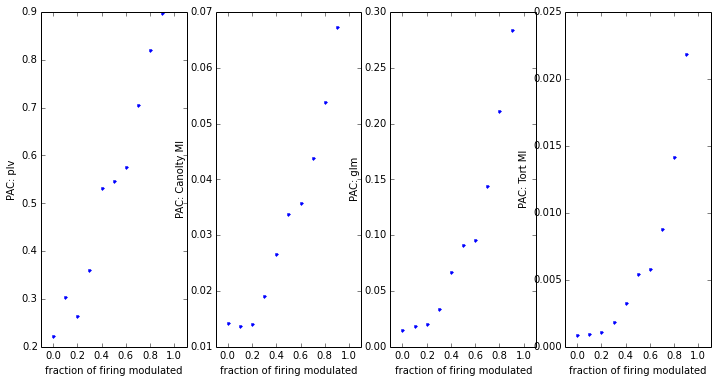

In [9]:
plt.figure(figsize=(12,6))
plt.subplot(1,4,1)
plt.plot(mod_frac,pac_plv,'.')
plt.xlabel('fraction of firing modulated')
plt.ylabel('PAC: plv')
plt.xlim([-.1,1.1])

plt.subplot(1,4,2)
plt.plot(mod_frac,pac_mi,'.')
plt.xlabel('fraction of firing modulated')
plt.ylabel('PAC: Canolty MI')
plt.xlim([-.1,1.1])

plt.subplot(1,4,3)
plt.plot(mod_frac,pac_glm,'.')
plt.xlabel('fraction of firing modulated')
plt.ylabel('PAC: glm')
plt.xlim([-.1,1.1])

plt.subplot(1,4,4)
plt.plot(mod_frac,pac_tort,'.')
plt.xlabel('fraction of firing modulated')
plt.ylabel('PAC: Tort MI')
plt.xlim([-.1,1.1])